In [ ]:
!pip install pytorch-lightning
!pip install nlp
!pip install transformers
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 798 kB 14.8 MB/s 
     |████████████████████████████████| 512 kB 91.6 MB/s 
     |████████████████████████████████| 125 kB 86.7 MB/s 
     |████████████████████████████████| 87 kB 8.1 MB/s 
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115943 sha256=42c27c6413c7fb397963bd391b149807291806af26a5f9ea0b68f7ba427ebd51
  Stored in directory: /root/.cache/pip/wheels/1f/10/06/2a990ee4d73a8479fe2922445e8a876d38cfbfed052284c6a1
Successfully built fire
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 14.7 MB/s 
     |████████████████████████████████| 212 kB 88.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 15.1 MB/s 
     |███████████

In [ ]:
import argparse
import glob
import os
import json
import time
import logging
import random
import re
from itertools import chain
from string import punctuation

import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

import pandas as pd
import numpy as np
import torch
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning.loggers import WandbLogger
from nlp import load_metric
import string
from pathlib import Path
from transformers import (
    AdamW,
    Adafactor,
    T5ForConditionalGeneration,
    T5Tokenizer,
    T5Config,
    get_linear_schedule_with_warmup
)
from torch.utils.data import RandomSampler

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Load My Data, Scraped From AskReddit

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving AskRedditTrain2.csv to AskRedditTrain2.csv


In [ ]:
uploaded = files.upload()

Saving AskRedditTest2.csv to AskRedditTest2.csv


In [ ]:
uploaded = files.upload()

Saving AskRedditVal2.csv to AskRedditVal2.csv


### Load my CSVs into huggingface NLP library dataset format

In [ ]:
from nlp import load_dataset
dataset = load_dataset('csv', data_files={'train': 'AskRedditTrain2.csv','validation': 'AskRedditVal2.csv','test': 'AskRedditTest2.csv'})

Downloading:   0%|          | 0.00/2.75k [00:00<?, ?B/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-483250cc4291ed48/0.0.0/ede98314803c971fef04bcee45d660c62f3332e8a74491e0b876106f3d99bd9b. Subsequent calls will reuse this data.


In [ ]:
print(dataset.keys())

dict_keys(['train', 'validation', 'test'])


In [ ]:
print("Size of train dataset: ", dataset['train'].shape)

Size of train dataset:  (13036, 3)


In [ ]:
print("Size of Validation dataset: ", dataset['validation'].shape)

Size of Validation dataset:  (2058, 3)


We can use the test data set for validation

In [ ]:
print("Size of test dataset: ", dataset['test'].shape)

Size of test dataset:  (2059, 3)


### Look at Examples in this data set

In [ ]:
print(dataset['train'][0].keys())

dict_keys(['', 'question', 'answer'])


In [ ]:
print(" Example of Question: ", dataset['train'][11]['question'])

 Example of Question:  What's the best way to gain confidence?


In [ ]:
print(" Example of Answer: ", dataset['train'][11]['answer'])

 Example of Answer:  Don’t go on the internet


### Inputs for T5 Model
Since this is a closed book question answering problem, we will take as input the question and fine tune the model to output the answer

### Estimate average length of Question and Answer

In [ ]:
tiny_dataset = dataset['train'].select(list(range(0, 500)))
ques_len = []
ans_len=[]

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
for i in range(len(tiny_dataset)):
    example = tiny_dataset[i]
    text_example = example['question']
    text_example = text_example.replace('\n','')
    text_words = text_example.split()
    ques_len.append(len(text_words))
    summary_example = example['answer']
    summary_example = summary_example.replace('\n','')
    summary_words = summary_example.split()
    ans_len.append(len(summary_words))

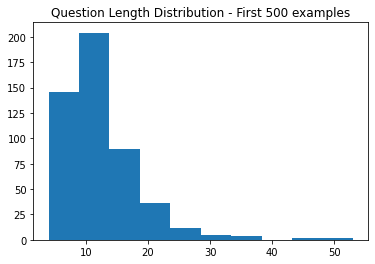

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(ques_len)
plt.title('Question Length Distribution - First 500 examples')
plt.show()

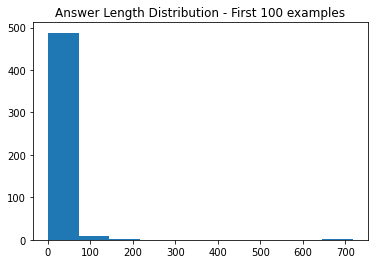

In [ ]:
plt.hist(ans_len)
plt.title('Answer Length Distribution - First 100 examples')
plt.show()

In [ ]:
print("Average Length of Question: ", sum(ques_len)/len(ques_len))

Average Length of Question:  12.096


In [ ]:
print("Average Length of Answer: ", sum(ans_len)/len(ans_len))

Average Length of Answer:  14.564


## Define Model

In [ ]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

In [ ]:
def normalize_answer(s):
    """Lower text and remove punctuation, articles and extra whitespace."""

    def remove_articles(text):
        return re.sub(r"\b(a|an|the)\b", " ", text)

    def white_space_fix(text):
        return " ".join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return "".join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))

In [ ]:
def exact_match_score(prediction, ground_truth):
    return int(normalize_answer(prediction) == normalize_answer(ground_truth))

def approx_match_score(prediction, ground_truth):
    answer = normalize_answer(prediction) 
    gt = normalize_answer(ground_truth)
    match = 0
    gt_words = gt.split(" ")
    for word in gt_words:
        if word in answer:
            match = 1
            return match
    return match

In [ ]:
def calculate_scores(predictions, ground_truths):
    em_score = 0
    subset_match_score = 0
    
    for i in range(len(predictions)):
        ground_truth = ground_truths[i]
        prediction = predictions[i]
        em_score +=  exact_match_score(prediction, ground_truth)
        subset_match_score += approx_match_score(prediction, ground_truth)
    
    em_score /= len(predictions)
    subset_match_score /= len(predictions)
    return em_score*100, subset_match_score*100
    

In [ ]:
class T5FineTuner(pl.LightningModule):
    def __init__(self, hparams):
        super(T5FineTuner, self).__init__()
        self.hparams.update(vars(hparams)) # modified this after extensively googling a 'can't set attribute' error
#         self.config = T5Config(hparams.model_name_or_path,dropout_rate=0.2)
        self.model = T5ForConditionalGeneration.from_pretrained(hparams.model_name_or_path)
#         self.model.dropout_rate=0.2
        self.tokenizer = T5Tokenizer.from_pretrained(hparams.tokenizer_name_or_path)
        
        if self.hparams.freeze_embeds:
            self.freeze_embeds()
        if self.hparams.freeze_encoder:
            self.freeze_params(self.model.get_encoder())
            assert_all_frozen(self.model.get_encoder())
        
        self.step_count = 0
        self.output_dir = Path(self.hparams.output_dir)
            
        n_observations_per_split = {
            "train": self.hparams.n_train,
            "validation": self.hparams.n_val,
            "test": self.hparams.n_test,
        }
        self.n_obs = {k: v if v >= 0 else None for k, v in n_observations_per_split.items()}
        self.em_score_list = []
        self.subset_score_list =[]
    
    def freeze_params(self, model):
        for par in model.parameters():
            par.requires_grad = False
            
            
    def freeze_embeds(self):
        """Freeze token embeddings and positional embeddings for bart, just token embeddings for t5."""
        try:
            self.freeze_params(self.model.model.shared)
            for d in [self.model.model.encoder, self.model.model.decoder]:
                freeze_params(d.embed_positions)
                freeze_params(d.embed_tokens)
        except AttributeError:
            self.freeze_params(self.model.shared)
            for d in [self.model.encoder, self.model.decoder]:
                self.freeze_params(d.embed_tokens)
    
    def lmap(self, f, x):
        """list(map(f, x))"""
        return list(map(f, x))
    

    def is_logger(self):
        return self.trainer.global_rank <= 0
    
        
    def forward(
      self, input_ids, attention_mask=None, decoder_input_ids=None, decoder_attention_mask=None, labels=None
  ):
        return self.model(
            input_ids,
            attention_mask=attention_mask,
            decoder_input_ids=decoder_input_ids,
            decoder_attention_mask=decoder_attention_mask,
            labels=labels,
    )

    def _step(self, batch):
        labels = batch["target_ids"]
        labels[labels[:, :] == self.tokenizer.pad_token_id] = -100

        outputs = self(
            input_ids=batch["source_ids"],
            attention_mask=batch["source_mask"],
            labels=labels,
            decoder_attention_mask=batch['target_mask']
        )

        loss = outputs[0]

        return loss
    
    
    def ids_to_clean_text(self, generated_ids):
        gen_text = self.tokenizer.batch_decode(
            generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True
        )
        return self.lmap(str.strip, gen_text)
    
    
    def _generative_step(self, batch) :
        
        t0 = time.time()
        
        generated_ids = self.model.generate(
            batch["source_ids"],
            attention_mask=batch["source_mask"],
            use_cache=True,
            decoder_attention_mask=batch['target_mask'],
            max_length=10,
            num_beams=2,
            early_stopping=True
        )
        preds = self.ids_to_clean_text(generated_ids)
        targets = self.ids_to_clean_text(batch["target_ids"])
            
        gen_time = (time.time() - t0) / batch["source_ids"].shape[0]  
    
        loss = self._step(batch)
        base_metrics = {'val_loss': loss}
        summ_len = np.mean(self.lmap(len, generated_ids))
        base_metrics.update(gen_time=gen_time, gen_len=summ_len, preds=preds, target=targets)
        em_score, subset_match_score = calculate_scores(preds, targets)
        
        self.em_score_list.append(em_score)
        self.subset_score_list.append(subset_match_score)
        
        em_score = torch.tensor(em_score,dtype=torch.float32)
        subset_match_score = torch.tensor(subset_match_score,dtype=torch.float32)
        
        base_metrics.update(em_score=em_score, subset_match_score=subset_match_score)
        
#         rouge_results = self.rouge_metric.compute() 
#         rouge_dict = self.parse_score(rouge_results)

        
        return base_metrics
    

    def training_step(self, batch, batch_idx):
        loss = self._step(batch)

        tensorboard_logs = {"train_loss": loss}
        return {"loss": loss, "log": tensorboard_logs}
  
    def training_epoch_end(self, outputs):
        avg_train_loss = torch.stack([x["loss"] for x in outputs]).mean()
        tensorboard_logs = {"avg_train_loss": avg_train_loss}
        # return {"avg_train_loss": avg_train_loss, "log": tensorboard_logs, 'progress_bar': tensorboard_logs}.    # error suggested commenting this out but this seems like not a good idea

    def validation_step(self, batch, batch_idx):
        return self._generative_step(batch)
    
  
    def validation_epoch_end(self, outputs):
        
        avg_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
        tensorboard_logs = {"val_loss": avg_loss}
        
        if len(self.em_score_list) <= 2:
            average_em_score = sum(self.em_score_list) / len(self.em_score_list) 
            average_subset_match_score = sum(self.subset_score_list)/len(self.subset_score_list)
            
        else:
            latest_em_score = self.em_score_list[:-2]
            latest_subset_score = self.subset_score_list[:-2]
            average_em_score = sum(latest_em_score) / len(latest_em_score) 
            average_subset_match_score = sum(latest_subset_score)/len(latest_subset_score)
            
        
        
        average_em_score = torch.tensor(average_em_score,dtype=torch.float32)
        average_subset_match_score = torch.tensor(average_subset_match_score,dtype=torch.float32)
        tensorboard_logs.update(em_score=average_em_score, subset_match_score=average_subset_match_score)
        
        ## Clear out the lists for next epoch
        self.target_gen= []
        self.prediction_gen=[]
        return {"avg_val_loss": avg_loss, 
                "em_score" : average_em_score,
                "subset_match_score" : average_subset_match_score,
                "log": tensorboard_logs, 'progress_bar': tensorboard_logs}

    def configure_optimizers(self):
        "Prepare optimizer and schedule (linear warmup and decay)"

        model = self.model
        no_decay = ["bias", "LayerNorm.weight"]
        optimizer_grouped_parameters = [
            {
                "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
                "weight_decay": self.hparams.weight_decay,
            },
            {
                "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
                "weight_decay": 0.0,
            },
        ]
        
#         optimizer = AdamW(optimizer_grouped_parameters, lr=self.hparams.learning_rate, eps=self.hparams.adam_epsilon)
        optimizer = Adafactor(optimizer_grouped_parameters, lr=self.hparams.learning_rate, scale_parameter=False,
                             relative_step=False)
        self.opt = optimizer
        return [optimizer]
  
    def optimizer_step(self, epoch, batch_idx, optimizer, optimizer_idx, optimizer_closure=None, second_order_closure=None, using_native_amp=False, on_tpu=None, using_lbfgs=None):
        # if self.trainer.use_tpu:
        #     xm.optimizer_step(optimizer)
        # else:
        optimizer.step(closure=optimizer_closure)
        optimizer.zero_grad()
        self.lr_scheduler.step()
  
    def get_tqdm_dict(self):
        tqdm_dict = {"loss": "{:.3f}".format(self.trainer.avg_loss), "lr": self.lr_scheduler.get_last_lr()[-1]}

        return tqdm_dict
    

    def train_dataloader(self):   
        n_samples = self.n_obs['train']
        train_dataset = get_dataset(tokenizer=self.tokenizer, type_path="train", num_samples=n_samples, args=self.hparams)
        sampler=RandomSampler(train_dataset)
        dataloader = DataLoader(train_dataset, sampler=sampler,  batch_size=self.hparams.train_batch_size, drop_last=True, num_workers=4, shuffle=False)
        t_total = (
            (len(dataloader.dataset) // (self.hparams.train_batch_size * max(1, self.hparams.n_gpu)))
            // self.hparams.gradient_accumulation_steps
            * float(self.hparams.num_train_epochs)
        )
        # t_total = 100000
        scheduler = get_linear_schedule_with_warmup(
            self.opt, num_warmup_steps=self.hparams.warmup_steps, num_training_steps=t_total
        )
        self.lr_scheduler = scheduler
        return dataloader

    def val_dataloader(self):
        n_samples = self.n_obs['validation']
        
        validation_dataset = get_dataset(tokenizer=self.tokenizer, type_path="validation", num_samples=n_samples, args=self.hparams)
        sampler=RandomSampler(validation_dataset)
        return DataLoader(validation_dataset, batch_size=self.hparams.eval_batch_size, sampler =sampler, num_workers=4, shuffle=False)
    
    
    def test_dataloader(self):
        n_samples = self.n_obs['test']
        test_dataset = get_dataset(tokenizer=self.tokenizer, type_path="test", num_samples=n_samples, args=self.hparams)
        
        return DataLoader(test_dataset, batch_size=self.hparams.eval_batch_size, num_workers=4, shuffle=False)
    
    
    def on_save_checkpoint(self, checkpoint):
        save_path = self.output_dir.joinpath("best_tfmr")
        self.model.config.save_step = self.step_count
        self.model.save_pretrained(save_path)
        self.tokenizer.save_pretrained(save_path)

In [ ]:
logger = logging.getLogger(__name__)

class LoggingCallback(pl.Callback):
    def on_validation_end(self, trainer, pl_module):
        logger.info("***** Validation results *****")
        if pl_module.is_logger():
            metrics = trainer.callback_metrics
            # Log results
            for key in sorted(metrics):
                if key not in ["log", "progress_bar"]:
                    logger.info("{} = {}\n".format(key, str(metrics[key])))

    def on_test_end(self, trainer, pl_module):
        logger.info("***** Test results *****")

        if pl_module.is_logger():
            metrics = trainer.callback_metrics

            # Log and save results to file
            output_test_results_file = os.path.join(pl_module.hparams.output_dir, "test_results.txt")
            with open(output_test_results_file, "w") as writer:
                for key in sorted(metrics):
                    if key not in ["log", "progress_bar"]:
                        logger.info("{} = {}\n".format(key, str(metrics[key])))
                        writer.write("{} = {}\n".format(key, str(metrics[key])))

## Define a DataSet class for the loader

In [ ]:
class AskReddit_QA_ClosedBook(Dataset):
    def __init__(self, tokenizer, type_path, num_samples, input_length, output_length, print_text=False):         
        self.dataset =  load_dataset('csv', data_files={'train': 'AskRedditTrain2.csv','validation': 'AskRedditVal2.csv','test': 'AskRedditTest2.csv'}, split=type_path)

        if num_samples:
            rand_indices = np.random.choice(self.dataset.shape[0], num_samples, replace=False)
            self.dataset = self.dataset.select(list(rand_indices))
        self.input_length = input_length
        self.tokenizer = tokenizer
        self.output_length = output_length
        self.print_text = print_text
  
    def __len__(self):
        return self.dataset.shape[0]
    
    def clean_text(self, text):
        text = text.replace('Example of Question:', '')
        text = text.replace('Example of Answer:', '')
        text = text.replace('\n','')
        text = text.replace('``', '')
        text = text.replace('"', '')
        
        return text
    
    
    def convert_to_features(self, example_batch):
        # Tokenize contexts and questions (as pairs of inputs)
        
        if self.print_text:
            print("Input Text: ", self.clean_text(example_batch['question']))
#         input_ = self.clean_text(example_batch['text']) + " </s>"
#         target_ = self.clean_text(example_batch['headline']) + " </s>"
        
        input_ = self.clean_text(example_batch['question'])  
        target_ = self.clean_text(example_batch['answer'])  
        
        source = self.tokenizer.batch_encode_plus([input_], max_length=self.input_length, 
                                                     padding='max_length', truncation=True, return_tensors="pt")
        
        targets = self.tokenizer.batch_encode_plus([target_], max_length=self.output_length, 
                                                     padding='max_length', truncation=True, return_tensors="pt")
    
       
        return source, targets
  
    def __getitem__(self, index):
        source, targets = self.convert_to_features(self.dataset[index])
        
        source_ids = source["input_ids"].squeeze()
        target_ids = targets["input_ids"].squeeze()

        src_mask    = source["attention_mask"].squeeze()
        target_mask = targets["attention_mask"].squeeze()

        return {"source_ids": source_ids, "source_mask": src_mask, "target_ids": target_ids, "target_mask": target_mask}
        
  

### Test the dataset function

In [ ]:
tokenizer = T5Tokenizer.from_pretrained('t5-base')
dataset = AskReddit_QA_ClosedBook(tokenizer, 'validation', None, 50, 175, True)      # 50, 175 = the input and output length, this was informed by looking at the distribution of length of my questions and answers

Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

/usr/local/lib/python3.8/dist-packages/transformers/models/t5/tokenization_t5.py:163: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


In [ ]:
data = dataset[50]
print()
print("Shape of Tokenized Text: ", data['source_ids'].shape)
print()
print("Sanity check - Decode Text: ", tokenizer.decode(data['source_ids']))
print("====================================")
print("Sanity check - Decode Summary: ", tokenizer.decode(data['target_ids']))

Input Text:  The exit to your room is blocked off by 50 people wanting to kill you. You’re on the opposite end of the room. Your only weapon is the pistol of your choice with 20 rounds of corresponding ammunition. How long can you survive?

Shape of Tokenized Text:  torch.Size([50])

Sanity check - Decode Text:  The exit to your room is blocked off by 50 people wanting to kill you. You’re on the opposite end of the room. Your only weapon is the pistol of your choice with 20 rounds of corresponding ammunition. How long can you survive</s>
Sanity check - Decode Summary:  I'm out the window, dude</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><

## Define Arguments

In [ ]:
args_dict = dict(
    output_dir="", # path to save the checkpoints
    model_name_or_path='t5-base',
    tokenizer_name_or_path='t5-base',
    max_input_length=50,
    max_output_length=175,
    freeze_encoder=False,
    freeze_embeds=False,
    learning_rate=1e-5,
    weight_decay=0.0,
    adam_epsilon=1e-8,
    warmup_steps=0,
    train_batch_size=4,
    eval_batch_size=4,
    num_train_epochs=2,
    gradient_accumulation_steps=1, # changed this to 1 from 10 because of an error... not sure how it works
    n_gpu=1,
    resume_from_checkpoint=None, 
    val_check_interval = 0.5, 
    n_val=-1, # changed this to -1 from 5000. i'm assuming -1 means use all the data that we have
    n_train=-1,
    n_test=-1,
    # early_stop_callback=False,
    fp_16=False, # if you want to enable 16-bit training then install apex and set this to true
    # opt_level='O1', # you can find out more on optimisation levels here https://nvidia.github.io/apex/amp.html#opt-levels-and-properties
    max_grad_norm=1.0, # if you enable 16-bit training then set this to a sensible value, 0.5 is a good default
    seed=101,
)

!mkdir -p t5_trivia_qa_closedbook

In [ ]:
args_dict.update({'output_dir': 't5_askreddit_qa_closedbook', 'num_train_epochs':10,
                 'train_batch_size': 48, 'eval_batch_size': 48, 'learning_rate': 1e-3})
                #  'resume_from_checkpoint': 't5_trivia_qa_closedbook/checkpointepoch=53.ckpt'})
args = argparse.Namespace(**args_dict)
print(args_dict)

{'output_dir': 't5_askreddit_qa_closedbook', 'model_name_or_path': 't5-base', 'tokenizer_name_or_path': 't5-base', 'max_input_length': 50, 'max_output_length': 175, 'freeze_encoder': False, 'freeze_embeds': False, 'learning_rate': 0.001, 'weight_decay': 0.0, 'adam_epsilon': 1e-08, 'warmup_steps': 0, 'train_batch_size': 48, 'eval_batch_size': 48, 'num_train_epochs': 10, 'gradient_accumulation_steps': 1, 'n_gpu': 1, 'resume_from_checkpoint': None, 'val_check_interval': 0.5, 'n_val': -1, 'n_train': -1, 'n_test': -1, 'fp_16': False, 'max_grad_norm': 1.0, 'seed': 101}


In [ ]:
## Define Checkpoint function
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath=args.output_dir, filename="checkpoint", mode="max", save_top_k=1, save_last=True  #here i took out monitor = 'subset_match_score' because a weird error was happening :/
)

## If resuming from checkpoint, add an arg resume_from_checkpoint
train_params = dict(
    accumulate_grad_batches=args.gradient_accumulation_steps,
    gpus=args.n_gpu,
    max_epochs=args.num_train_epochs,
    # early_stop_callback=False,
    precision= 16 if args.fp_16 else 32,
    # amp_level=args.opt_level,
    resume_from_checkpoint=args.resume_from_checkpoint,
    gradient_clip_val=args.max_grad_norm,
    # checkpoint_callback=checkpoint_callback,  # this caused an error, had to add to 'callbacks =' line
    val_check_interval=args.val_check_interval,
    # logger=wandb_logger,
    callbacks=[LoggingCallback(), checkpoint_callback],
)

In [ ]:
def get_dataset(tokenizer, type_path, num_samples, args):
      return AskReddit_QA_ClosedBook(tokenizer=tokenizer, type_path=type_path, num_samples=num_samples,  input_length=args.max_input_length, 
                        output_length=args.max_output_length)

## Train Model

In [ ]:
model = T5FineTuner(args)

Downloading:   0%|          | 0.00/892M [00:00<?, ?B/s]

In [ ]:
trainer = pl.Trainer(**train_params)

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | T5ForConditionalGeneration | 222 M 
-----------------------------------------------------
222 M     Trainable params
0         Non-trainable params
222 M     Total params
891.614   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [ ]:
# torch.save(model.state_dict(),'drive/MyDrive/models/just_in_case.bin')
# !cp -R t5_askreddit_qa_closedbook/* drive/MyDrive/models
model.model.save_pretrained('drive/MyDrive/models/from_pretrained')
tokenizer.save_pretrained('drive/MyDrive/models/from_pretrained')

('drive/MyDrive/models/from_pretrained/tokenizer_config.json',
 'drive/MyDrive/models/from_pretrained/special_tokens_map.json',
 'drive/MyDrive/models/from_pretrained/spiece.model',
 'drive/MyDrive/models/from_pretrained/added_tokens.json')